In [27]:
# Importing libraries

import re
import pandas as pd
import numpy as np
import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization, SimpleRNN,TimeDistributed
from tensorflow.keras import Sequential

#### Dataset Loading

In [28]:
# reading data

data = pd.read_csv(r'googleplaystore_user_reviews.csv')

data.head()

,App,Translated_Review,Sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive
2,10 Best Foods for You,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive
4,10 Best Foods for You,Best idea us,Positive


In [29]:
# drop unnecessary columns and rename cols

data.drop(['App'], axis=1, inplace=True)

data.columns = ['review', 'sentiment']

data.head()

,review,sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,NaN,NaN
3,Works great especially going grocery store,Positive
4,Best idea us,Positive


#### EDA

In [30]:
# check data shape

data.shape

(64295, 2)

In [31]:
# check missing values

data.isna().sum()

,0
review,26868
sentiment,26863


In [32]:
# dropping null values

data.dropna(inplace=True)

<Axes: xlabel='sentiment'>

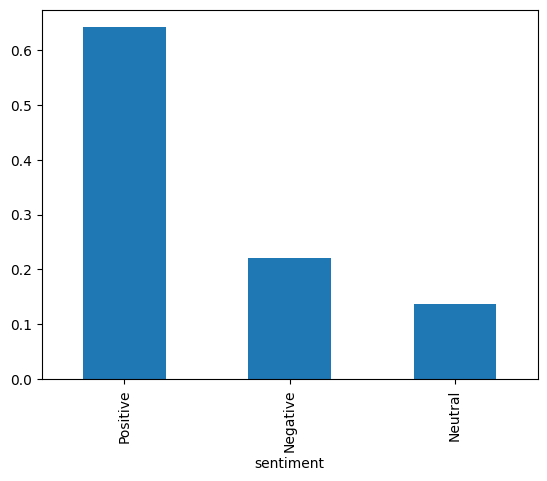

In [33]:
# check target balance

data['sentiment'].value_counts(normalize = True).plot.bar()

#### Text Preprocessing pipeline

In [34]:
# text preprocessing

def preprocess_pipeline(text_data):
    # create a list text

    lemmatizer = WordNetLemmatizer()

    if str(type(text_data)) != "<class 'str'>":
        text = list(text_data)

        # preprocessing loop

        corpus = []

        for i in range(len(text)):

            r = re.sub('[^a-zA-Z]', ' ', text[i])

            r = r.lower()

            r = r.split()

            # r = [word for word in r if word not in stopwords.words('english')] Stopwords removal not required

            r = [lemmatizer.lemmatize(word) for word in r] # lemmatization is still ok.

            r = ' '.join(r)

            corpus.append(r)

        return corpus

    else:

        r = re.sub('[^a-zA-Z]', ' ', text_data)

        r = r.lower()

        r = r.split()

        r = [word for word in r if word not in stopwords.words('english')]

        r = [lemmatizer.lemmatize(word) for word in r]

        r = ' '.join(r)

        return r

In [35]:
#assign corpus to data['text']
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
preprocessed_text = preprocess_pipeline(data['review'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
data['review'] = preprocessed_text

data.head()

,review,sentiment
0,i like eat delicious food that s i m cooking f...,Positive
1,this help eating healthy exercise regular basis,Positive
3,work great especially going grocery store,Positive
4,best idea u,Positive
5,best way,Positive


In [37]:
# data.to_csv('sentiments_cleaned_data.csv', index=False)

In [38]:
data.head()

,review,sentiment
0,i like eat delicious food that s i m cooking f...,Positive
1,this help eating healthy exercise regular basis,Positive
3,work great especially going grocery store,Positive
4,best idea u,Positive
5,best way,Positive


#### Train-Test split

In [39]:
# Create Feature and Label sets

X = data['review']

y = data['sentiment']


# train test split (66% train - 33% test)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print('Training Data :', X_train.shape)

print('Testing Data : ', X_test.shape)

Training Data : (26198,)
Testing Data :  (11229,)


In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Feature Extraction

#### Using Embeddings in Keras library

In [41]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [42]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size # this gives number of unique tokens. This will be our input_sequences

15508

In [43]:
# Pad the sequences to a fixed length
max_length = 300
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

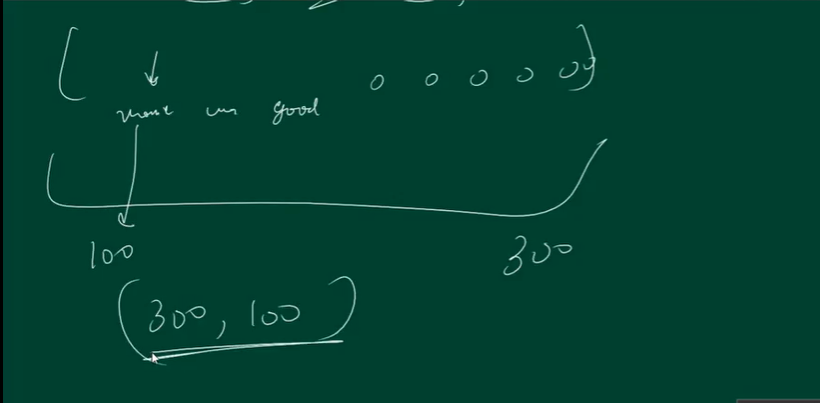

In [44]:
'''
This means if in my 1st review I have 3 words like Movie was Good. Then  0's are padded to make it 300.
Next every work embedding like movie, was, good has an embedding of length 100.
i.e at different timestamp , i will send different word.

'''


"\nThis means if in my 1st review I have 3 words like Movie was Good. Then  0's are padded to make it 300.\nNext every work embedding like movie, was, good has an embedding of length 100.\ni.e at different timestamp , i will send different word.\n\n"

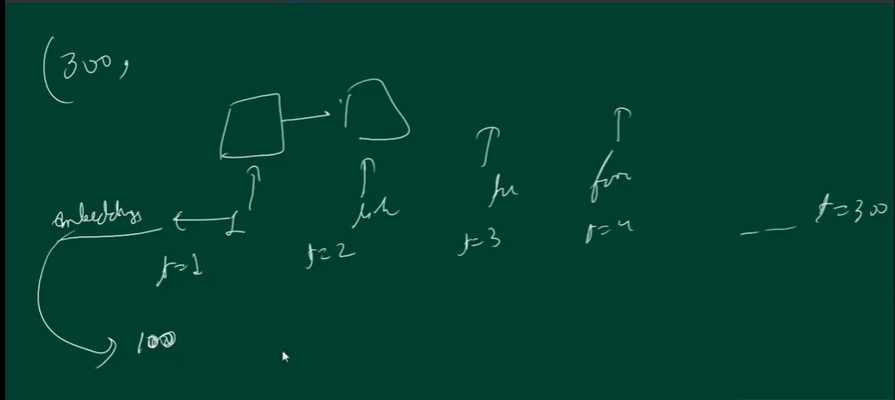

In [45]:
# Define the ANN model
# So number of features =  size of embeddings.
# so the shape is (300,100) . This will go as an i/p to our model.
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=5, input_length=max_length))
model.add(SimpleRNN(32,return_sequences=False, recurrent_dropout=0.2)) # recurrent dropout is same as dropout layer
# return_sequences=True means after every i/p , I want o/p.
model.add(Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

i.e. for return_sequences=True
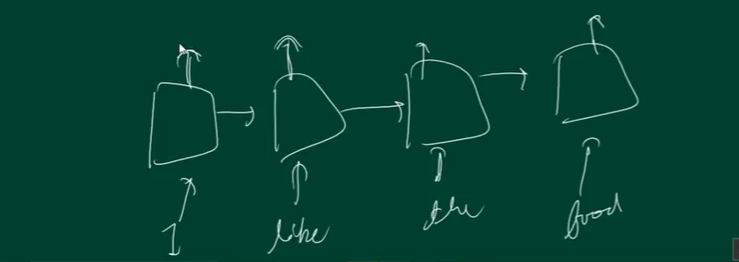

In [ ]:
'''
so, return_sequences = True is an eg of many to many
Another case is many to 1, i.e. sentiment analysis case-- which we r doing.
'''

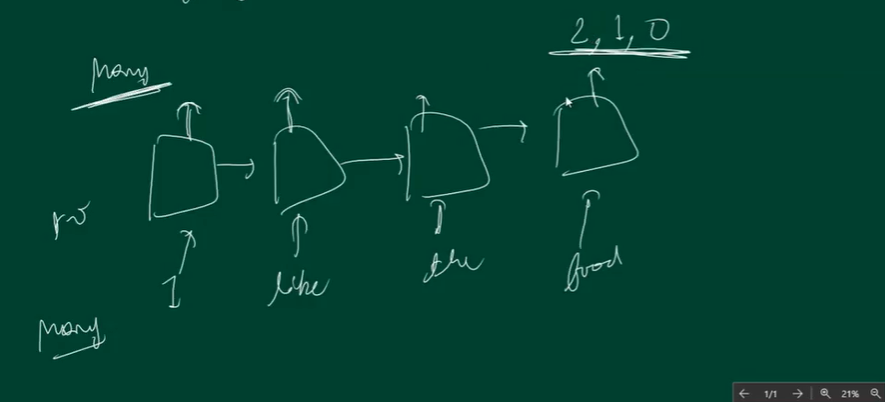

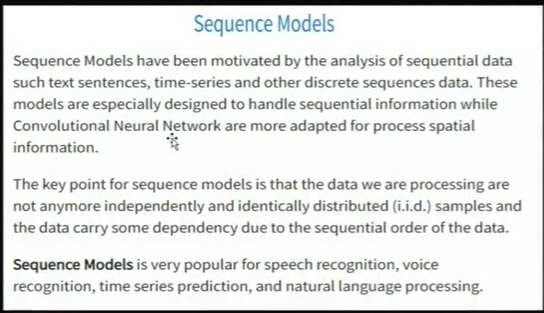

In [46]:
'''
Now, in RNN how data is sent ? It is sent in the form of - (number of timestamps,features)
The features here are vectors of the tokens. For eg in word2vec we create embedding of shape 300,
the the number of features in embeddings are 300.
now lets suppose, we have 3 sentences--
movie was good -- 3 timestamps i.e. at t=1, word is movie, t=2, word is was, t=3, word is good and if number of features=50, then (3,50)
movie was not good -- 4 timestamps (4,50)
movie was bad -- 3 timestamps (3,50)

If RNN architecture has 50 features so, i/p shape=50, After i/p layer comes Recurrent layer instead of Hidden layer.
# The difference here is the o/p (i.e. embedding learning) is given to next layer and also to all the units below.


'''

'\nNow, in RNN how data is sent ? It is sent in the form of - (number of timestamps,features)\nThe features here are vectors of the tokens. For eg in word2vec we create embedding of shape 300,\nthe the number of features in embeddings are 300.\nnow lets suppose, we have 3 sentences--\nmovie was good -- 3 timestamps i.e. at t=1, word is movie, t=2, word is was, t=3, word is good and if number of features=50, then (3,50)\nmovie was not good -- 4 timestamps (4,50)\nmovie was bad -- 3 timestamps (3,50)\n\nIf RNN architecture has 50 features so, i/p shape=50, After i/p layer comes Recurrent layer instead of Hidden layer.\n# The difference here is the o/p (i.e. embedding learning) is given to next layer and also to all the units below.\n\n\n'

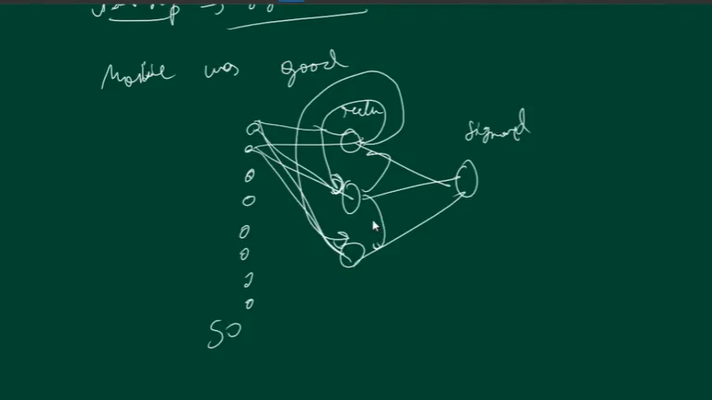

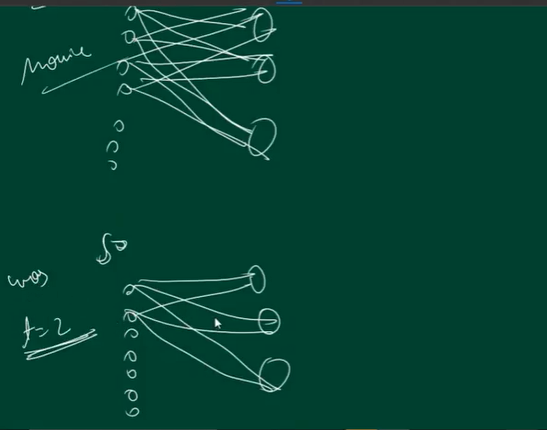

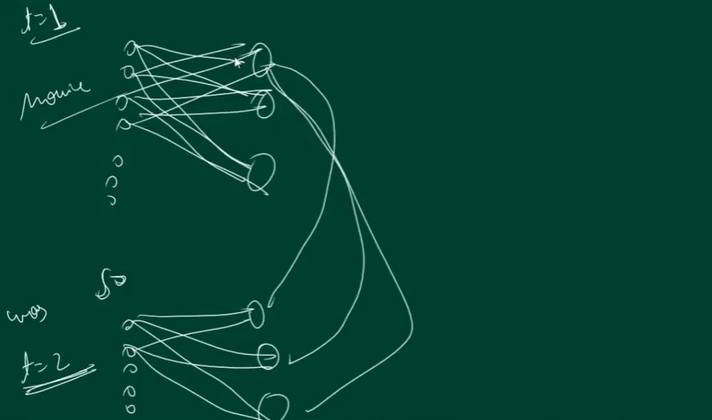

In [47]:
'''
the t=2 timestamp o/p would be given to t=3 i.e. movie to was to good and from last timestamp the o/p would be given.
So the number of weights and biases will be --
So if 50 i/p features given to 3 units of rnn whose o/p is given to next layer 3 rnn. So 50*3+3, 3*3+3, 3*1+1
These many parameters for 1st timestamp.
For 2nd timestamp --50*3+3, 3*3+3, 3*1+1
For 3rd timestamp --50*3+3, 3*3+3, 3*1+1

'''

'\nthe t=2 timestamp o/p would be given to t=3 i.e. movie to was to good and from last timestamp the o/p would be given.\nSo the number of weights and biases will be --\nSo if 50 i/p features given to 3 units of rnn whose o/p is given to next layer 3 rnn. So 50*3+3, 3*3+3, 3*1+1\nThese many parameters for 1st timestamp.\nFor 2nd timestamp --50*3+3, 3*3+3, 3*1+1\nFor 3rd timestamp --50*3+3, 3*3+3, 3*1+1\n\n'

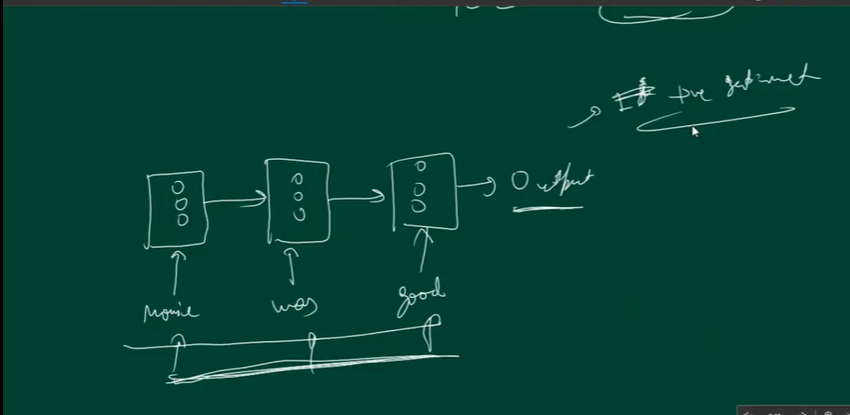

In [48]:
'''
Different types of RNN's :-
'''

"\nDifferent types of RNN's :-\n"

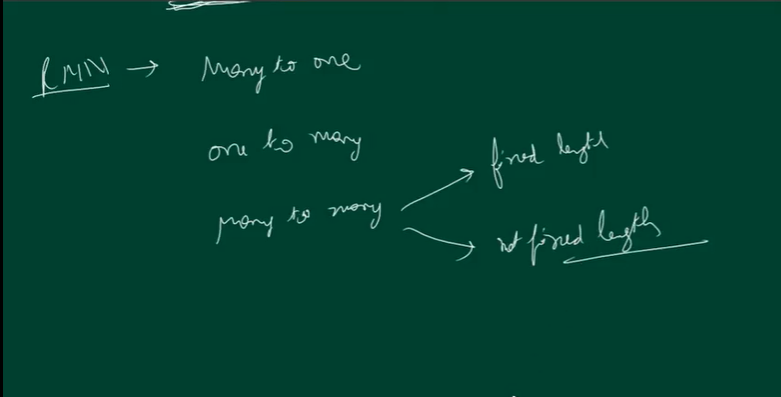

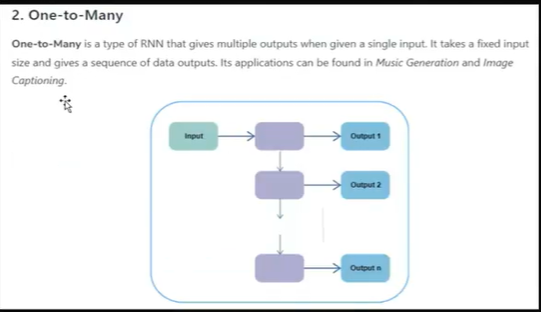

In [49]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.4659 - loss: 1.0682 - val_accuracy: 0.6439 - val_loss: 0.8897
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6404 - loss: 0.9150 - val_accuracy: 0.6439 - val_loss: 0.8906
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6393 - loss: 0.8991 - val_accuracy: 0.6439 - val_loss: 0.8910
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6440 - loss: 0.8904 - val_accuracy: 0.6439 - val_loss: 0.8906
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6399 - loss: 0.8923 - val_accuracy: 0.6439 - val_loss: 0.8892
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6438 - loss: 0.8893 - val_accuracy: 0.6439 - val_loss: 0.8895
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6404 - loss: 0.8937 - val_accuracy: 0.6439 - val_loss: 0.8897
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6428 - loss: 0.8889 - 

In [50]:
probabilities = model.predict(X_test)

probabilities

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


array([[0.22235198, 0.12531996, 0.65232813],
       [0.222301  , 0.12579873, 0.65190023],
       [0.22234043, 0.12542818, 0.65223145],
       ...,
       [0.22229426, 0.12586215, 0.6518436 ],
       [0.22234766, 0.12536052, 0.65229183],
       [0.22233227, 0.12550499, 0.6521628 ]], dtype=float32)

In [51]:
predictions = np.argmax(probabilities, axis=1)

predictions

array([2, 2, 2, ..., 2, 2, 2])

In [52]:
# confusion matrix
from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions),index=['Negative','Neutral','Positive'], columns=['Negative','Neutral','Positive'])

df

,Negative,Neutral,Positive
Negative,0,0,2481
Neutral,0,0,1548
Positive,0,0,7200


In [53]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.41
Recall: 0.64


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
# Overall our model didnt performed very good so, we need to apply multiple rnn's or tweak our logic a little.